# Uncertainties in Deep Learning (for Classification)

Machine learning techniques have found their way into everyday's life with their applicability ranging from virtual assistant's like Amazon's Alexa to self driving cars and applications in medicine as cancer prediction from images. Especially in the latter (and also self driving cars) a wrong decision can lead to catastrophic results endagering the life of patients or pedestrians. As machine learning based and especially deep learning based models generally perform better as other comparable possibilities the goal is to extend the framework to reduce the risk of falsely conducted actions based on the model's output. In this post we will incorporate uncertainty in the model's prediction, it shall be able to provide a quantitative measure for how certain it is with its results. For results with high uncertainty we can subsequently conclude the model simply does not know, which is the right answer.

## Decomposition of Uncertainty

Before we dive deeper into how to estimate uncertainty we must first decompose it into data- and model-dependent uncertainy.

### Aleatoric Uncertainty

Aleatoric uncertainty describes the uncertainty or noise inherent in the data. 

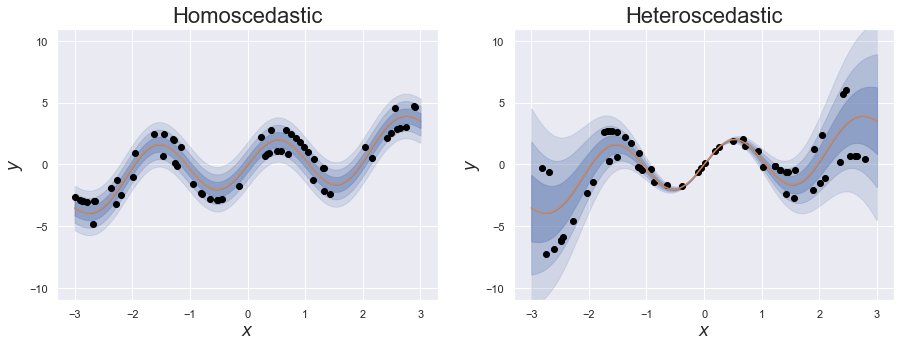

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.ndimage import gaussian_filter1d

f = lambda x: 0.1 * x**3 + 2 * np.sin(3*x)

x = np.linspace(-3, 3, 1000)
y = f(x)

hetero_noise = lambda x: 0.3 * x**2
hetero_sig = np.array([np.abs(h) for h in hetero_noise(x)])

homo_noise = 0.6
homo_sig = np.array([np.abs(homo_noise) for _ in range(len(x))])

alphas = [0.2, 0.3, 0.5]

fig, axs = plt.subplots(1, 2, figsize=(15,5))
for ax, uncert, title in zip(axs, [homo_sig, hetero_sig], [r'Homoscedastic', r'Heteroscedastic']):
    ax.plot(x,y, color='#D1895C')
    for i in range(1, 4):
        ax.fill_between(x, y, gaussian_filter1d(y + (4-i) * uncert, sigma=2), alpha=alphas[i-1], color='#6C85B6')
        ax.fill_between(x, y, gaussian_filter1d(y - (4-i) * uncert, sigma=2), alpha=alphas[i-1], color='#6C85B6')
    for op in [np.subtract, np.add]:
        idx = np.random.choice(np.arange(1000), size=30)
        ax.scatter(x[idx], op(y, 1.5*uncert)[idx], color='black')
    ax.set_ylim(-11, 11)
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.set_xlabel(r'$x$', fontsize=17)
    ax.set_ylabel(r'$y$', fontsize=17)
    ax.set_title(title, fontsize=22)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer, AdamW
from torch.utils.data import DataLoader

from layers import LinearLRT, Conv2dLRT, MCDropout

class LeNet5(nn.Module):

    def __init__(self, n_classes: int, vi_type: str = 'mean_field', p: float = 0.5):
        super(LeNet5, self).__init__()
        
        if vi_type == 'mean_field':
            conv = Conv2dLRT
            linear = LinearLRT
            self._kl = 'vi'
        elif vi_type == 'mc_dropout':
            conv = lambda in_channels, out_channels, kernel_size, stride: nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
                MCdropout(p=p, dim='2d')
            )
            linear = lambda in_features, out_features: nn.Sequential(
                nn.Linear(in_features=in_features, out_features=out_features),
                MCdropout(p=p, dim='1d')
            )
            self._kl = None
        else:
            conv = nn.Conv2d
            linear = nn.Linear
            self._kl = None
        
        self.feature_extractor = nn.Sequential(            
            conv(in_channels=1, out_channels=6, kernel_size=3, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            conv(in_channels=6, out_channels=16, kernel_size=3, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            conv(in_channels=16, out_channels=120, kernel_size=3, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            linear(in_features=1080, out_features=200),
            nn.Tanh(),
            linear(in_features=200, out_features=n_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs, self.kl_div()
    
    def kl_div(self) -> torch.Tensor:
        if self._kl is None:
            return torch.tensor([0])
        else:
            return torch.tensor([m.kl for m in self.children() if isinstance(m, (LinearLRT, Conv2dLRT))]).sum()

In [3]:
from typing import Union

def get_beta(beta_type: Union[float, str] = 1., batch_idx: int = 1, m: int = 1, 
             epoch: int = 1, n_epochs: int = 1) -> float:
    if beta_type == "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif beta_type == "Standard":
        beta = 1 / m
    else:
        beta = beta_type
    return beta

def gaussian_nll(mu: torch.Tensor, logvar: torch.Tensor, target: torch.Tensor, 
                 reduction: str = 'mean') -> torch.Tensor:
    loss = torch.exp(-logvar) * torch.pow(target - mu, 2) + logvar
    return loss.mean() if reduction=='mean' else loss.sum()

class ELBO(nn.Module):
    def __init__(self, train_size: int = 1, criterion: str = 'regression'):        
        super(ELBO, self).__init__()
        self.train_size = train_size
        #self.reduction = 'mean' if train_type == 'regression' else 'sum'
        if criterion == 'regression':
            self.nll = lambda inputs, target: gaussian_nll(inputs[:,0], inputs[:,1], target[:,0], 'mean')
        elif criterion == 'classification':
            self.nll = lambda inputs, target: F.cross_entropy(inputs, target)
        else:
            self.nll = lambda inputs, target: criterion(inputs, target)

    def forward(self, inputs: torch.Tensor, target: torch.Tensor, kl: torch.Tensor, 
                beta: float = 1.) -> torch.Tensor:
        return self.nll(inputs, target) * self.train_size + beta * kl

In [4]:
from tqdm import tqdm

def train_epoch(train_loader: DataLoader, model: nn.Module, criterion: nn.Module, optimizer: Optimizer, 
                epoch: int, n_epochs: int, beta_type: Union[float, str] = 1., device: str = 'cpu') -> float:
    
    model.train()
    running_loss = 0
    
    for batch_idx, (X, y) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        
        X = X.to(device)
        y = y.to(device)
    
        y_hat, _, kl = model(X) 
        beta = get_beta(beta_type=beta_type, batch_idx=batch_idx, m=len(train_loader), epoch=epoch, n_epochs=n_epochs)
        loss = criterion(y_hat, y, kl, beta)
        
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [5]:
from typing import Callable

def validate(valid_loader: DataLoader, model: nn.Module, criterion: Union[Callable, nn.Module], 
             device: str = 'cpu') -> float:

    model.eval()
    running_loss = 0
    accuracies = []
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)
        
    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return epoch_loss

In [6]:
def calc_accuracy(labels: torch.Tensor, targets: torch.Tensor) -> float:
    return torch.sum((labels == targets)).item() * 100.0 / len(labels)

def calc_uncert(p_hat: torch.Tensor, reduction: str = 'sum') -> (torch.Tensor):
    p_mean = torch.mean(p_hat, dim=0)
    ale = torch.mean(p_hat*(1-p_hat), dim=0)
    epi = torch.mean(p_hat**2, dim=0) - p_mean**2
    if reduction == 'sum':
        ale = torch.sum(ale, dim=1)
        epi = torch.sum(epi, dim=1)
    elif reduction == 'top':
        ale = torch.tensor([a[i] for a, i in zip(ale, torch.argmax(p_mean, dim=1))])
        epi = torch.tensor([e[i] for e, i in zip(epi, torch.argmax(p_mean, dim=1))])
    uncert = ale + epi
    return uncert, ale, epi

def analyse_predictions(model: nn.Module, data_loader: DataLoader, mc_iter: int = 25, device: str = 'cpu') -> (float):
    accuracies, uncerts = [], []
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            
            y_preds = []
            for _ in range(mc_iter):
                _, y_prob, _ = model(X)
                y_preds.append(y_prob.unsqueeze(0))
            y_preds = torch.cat(y_preds, dim=0)
            
            y_mean = torch.mean(y_preds, dim=0)
            accuracies.append(calc_accuracy(torch.argmax(y_mean, dim=1), y))
            
            uncert, ale, epi = calc_uncert(y_preds, reduction='top')
            uncerts.append(uncert)
    
    return np.mean(accuracies), torch.mean(torch.cat(uncerts)).item()

In [7]:
def train(model: nn.Module, criterion: nn.Module, optimizer: Optimizer, train_loader: DataLoader, 
          valid_loader: DataLoader, n_epochs: int, beta_type: Union[float, str] = 1.,  
          mc_iter: int = 25, device: str = 'cpu', print_every: int = 1) -> ([float]):
    
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    for epoch in range(0, n_epochs):

        train_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, n_epochs, beta_type, device)
        train_losses.append(train_loss)

        with torch.no_grad():
            valid_loss = validate(valid_loader, model, F.cross_entropy, device)
            valid_losses.append(valid_loss)

        if not epoch % print_every:
            
            #train_acc = get_acc_and_uncert(model, train_loader, device=device)
            valid_acc, valid_uncerts = analyse_predictions(model, valid_loader, device=device)
                
            print(f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  #f'Train accuracy: {train_acc:.2f}\t'
                  f'Valid accuracy: {valid_acc:.2f}\t'
                  f'Valid uncert: {valid_uncerts:.4f}')
    
    return train_losses, valid_losses, valid_uncerts

In [8]:
RANDOM_SEED = 42
LR = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 1
N_CLASSES = 10
WEIGHT_DECAY = 0.

In [9]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                               ])

train_loader = DataLoader(datasets.MNIST('datasets', 
                                         download=False, 
                                         train=True,
                                         transform=transform), 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True)

valid_loader = DataLoader(datasets.MNIST('datasets', 
                                         download=False, 
                                         train=False,
                                         transform=transform),
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LeNet5(n_classes=N_CLASSES).to(device)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
elbo = ELBO(len(train_loader.dataset), criterion='classification').to(device)

train_losses, valid_losses, valid_uncerts = train(model, elbo, optimizer, train_loader, 
                                                  valid_loader, n_epochs=N_EPOCHS, device=device)

1875it [01:06, 28.24it/s]


Epoch: 0	Train loss: 15719.4742	Valid loss: 0.1264	Valid accuracy: 96.50	Valid uncert: 0.0340


In [11]:
mc_iter = 25

preds = {
    'right': {'img': [], 'label_true': [], 'label_pred': [], 'pred_vec': [], 'uncerts': [], 'ales': [], 'epis': []},
    'wrong': {'img': [], 'label_true': [], 'label_pred': [], 'pred_vec': [], 'uncerts': [], 'ales': [], 'epis': []}
}

with torch.no_grad():
    for X, y in tqdm(valid_loader):
        X = X.to(device)
        y = y.to(device)

        y_preds = []
        for _ in range(mc_iter):
            _, y_prob, _ = model(X)
            y_preds.append(y_prob.unsqueeze(0))
        y_preds = torch.cat(y_preds, dim=0)
        
        y_pred_mean = torch.mean(y_preds, dim=0)
        y_pred = torch.argmax(y_pred_mean, dim=1)

        uncerts, ales, epis = calc_uncert(y_preds, reduction=None)

        for results in zip(X, y, y_pred, y_pred_mean, uncerts, ales, epis):
            pred_label = 'right' if results[1] == results[2] else 'wrong'
            for key, value in zip(list(preds[pred_label].keys()), results):
                preds[pred_label][key].append(value)

100%|██████████| 313/313 [01:04<00:00,  4.89it/s]


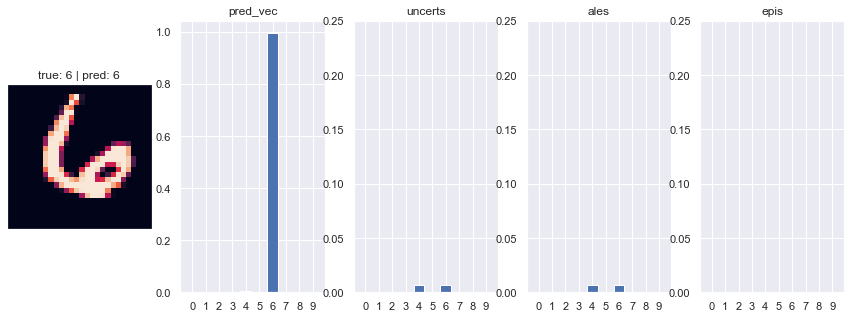

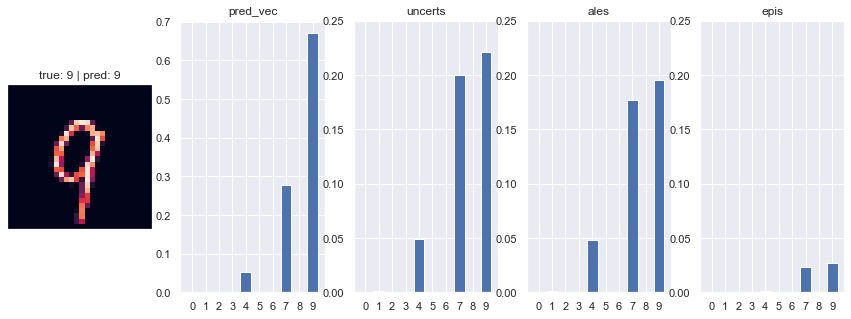

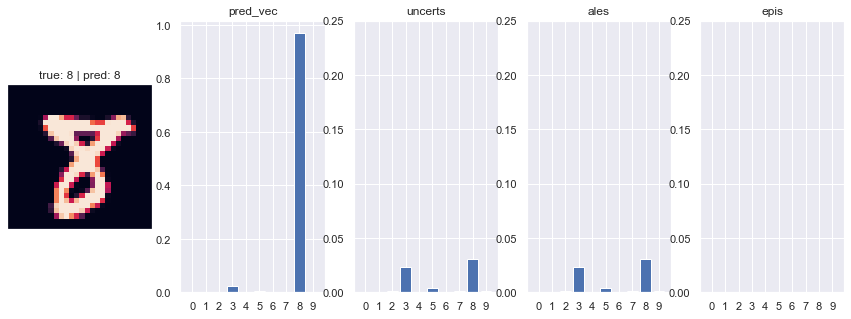

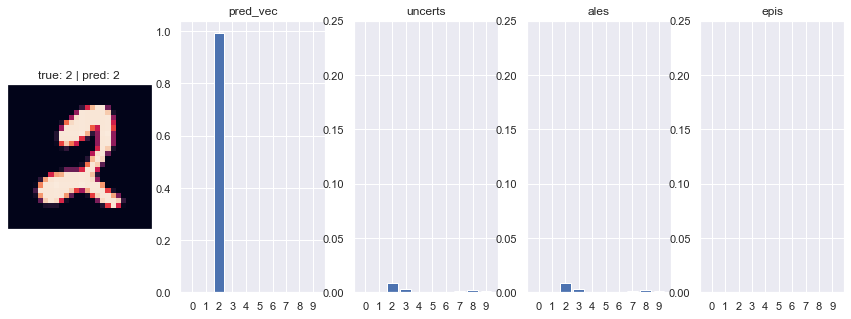

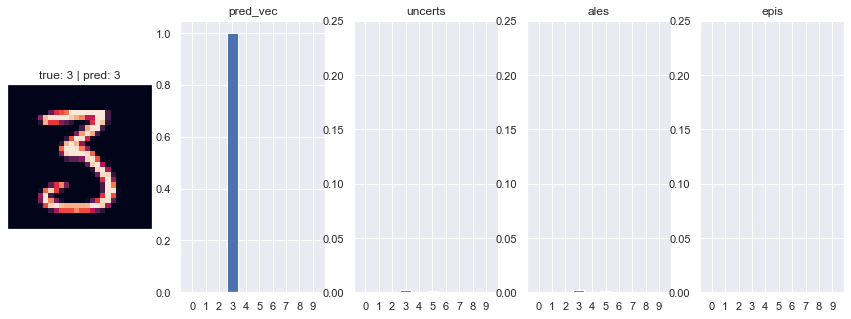

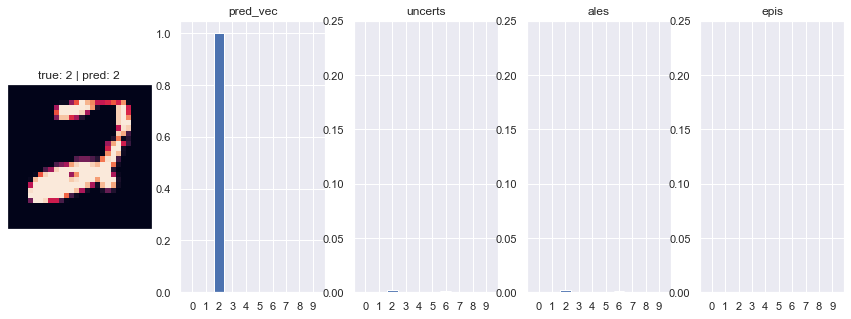

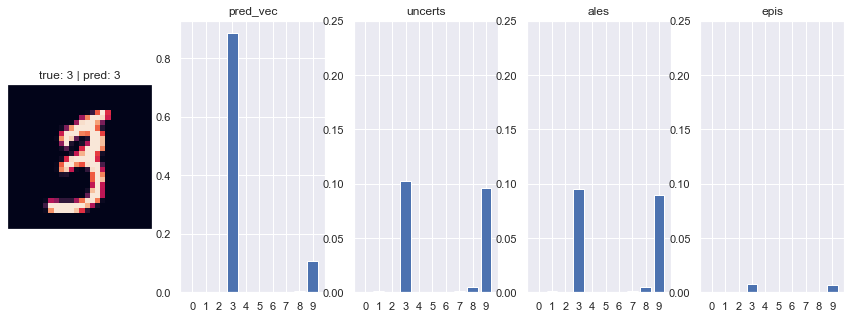

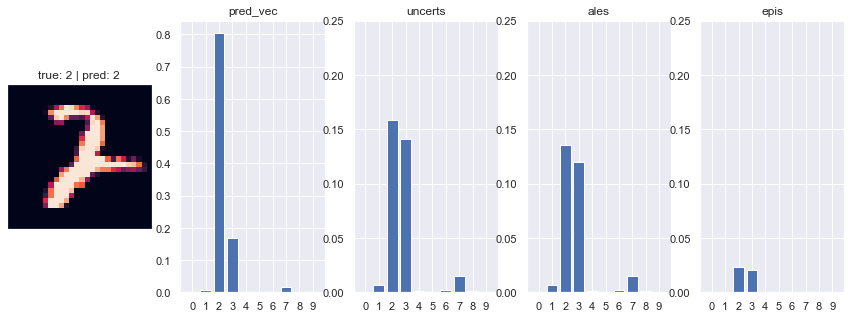

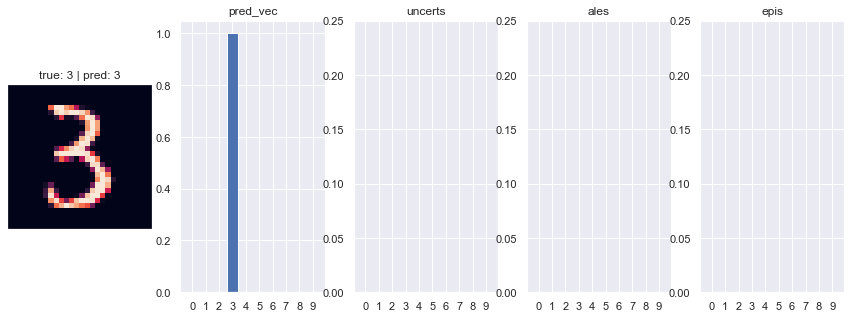

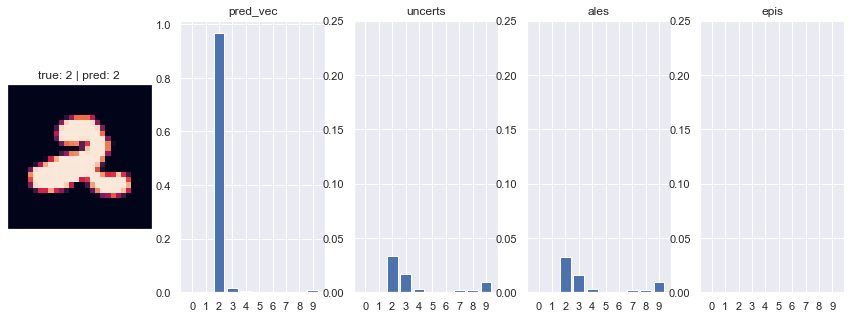

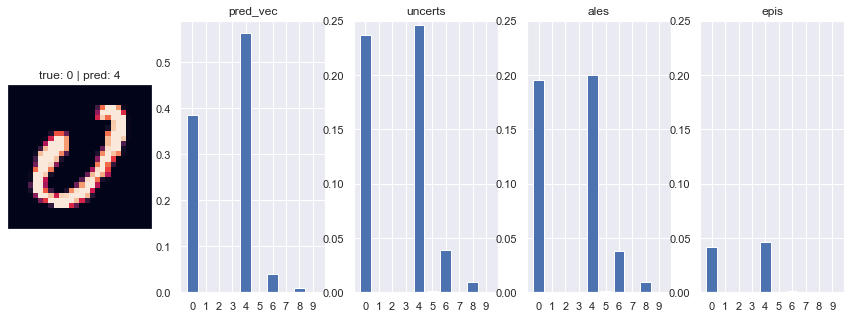

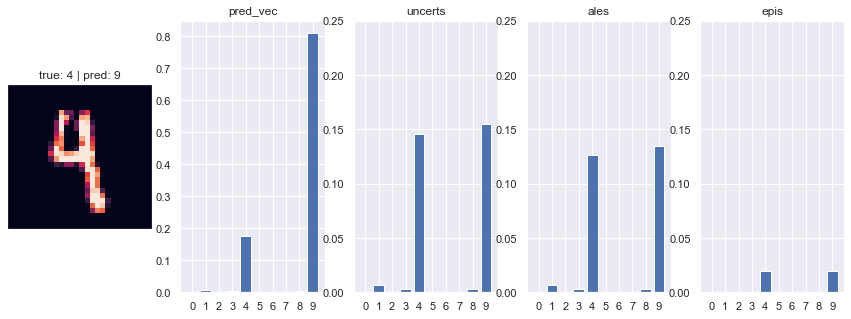

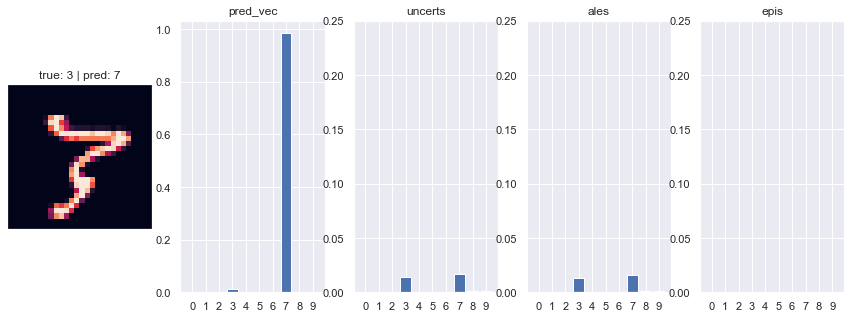

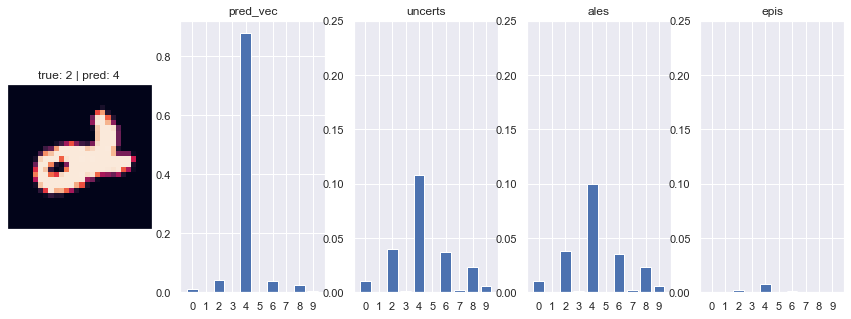

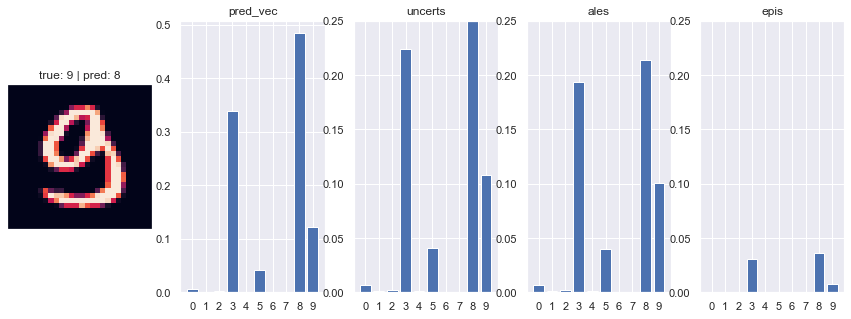

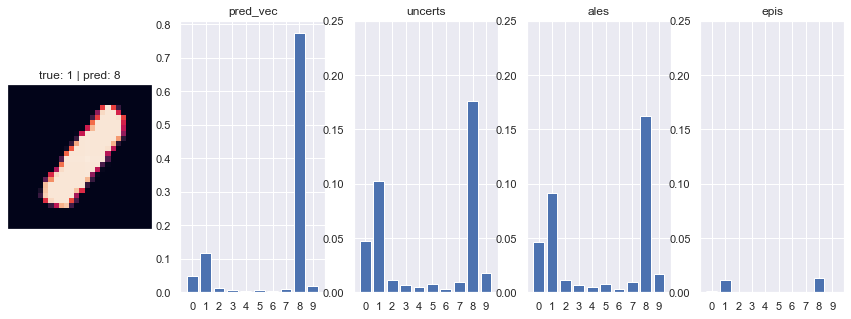

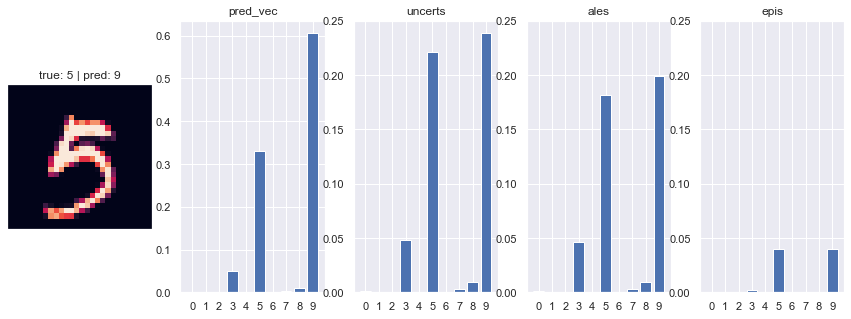

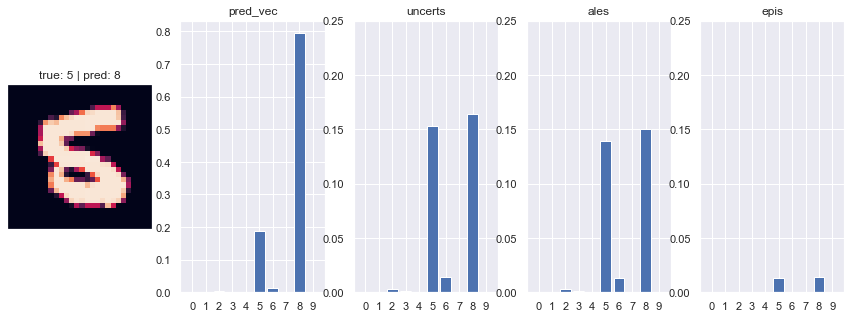

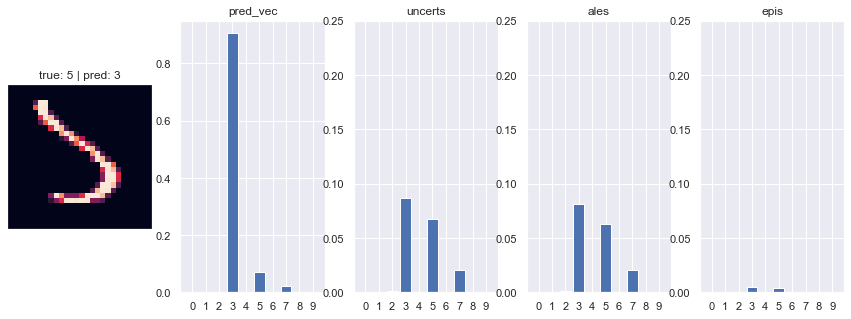

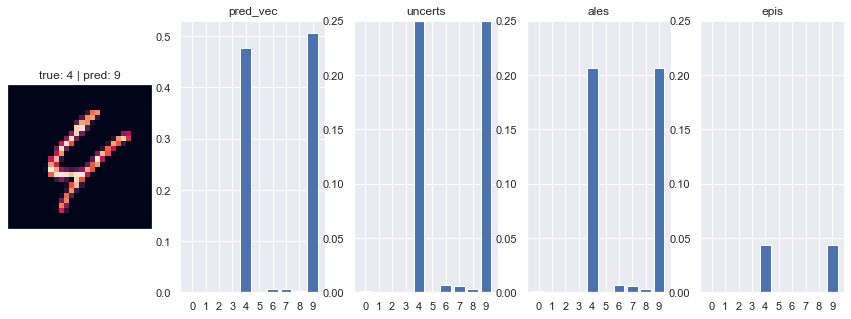

In [12]:
n = 10
for key in ['right', 'wrong']:
    idxs = np.random.choice(len(preds[key]['label_true']), n, replace=False)
    for idx in idxs:
        fig, axs = plt.subplots(1, 5, figsize=(15,5))
        axs[0].imshow(preds[key]['img'][idx].cpu().numpy()[0])
        axs[0].grid(False)
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        axs[0].set_title(r'true: %d | pred: %d' % (preds[key]['label_true'][idx], (preds[key]['label_pred'][idx])))
        for i, uncert in zip(range(1, 5), ['pred_vec', 'uncerts', 'ales', 'epis']):
            axs[i].bar(np.arange(0,10,1), preds[key][uncert][idx].cpu().numpy())
            if i != 1:
                axs[i].set_ylim([0, 0.25])
            axs[i].set_xticks(np.arange(0,10,1))
            axs[i].set_title(uncert)
        plt.show()